# Gradient Field and Decision Boundary

## Data for Classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

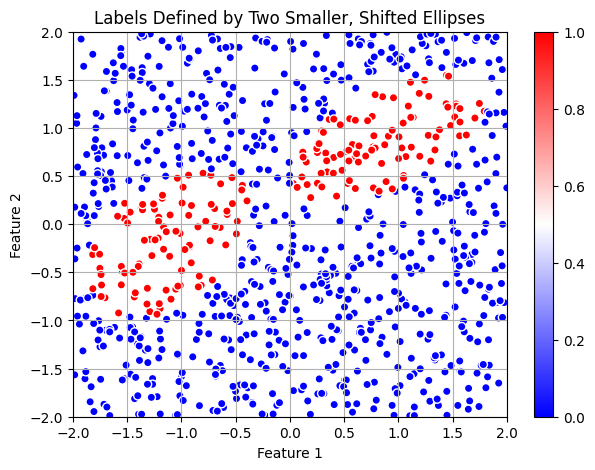

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

N = 900  # Number of samples

# Generate the same random points in the range [-2, 2] x [-2, 2]
X = torch.rand(N, 2) * 4 - 2  # Unchanged points

# Define parameters for two smaller, shifted ellipses
a1, b1 = 1.0, 0.5
a2, b2 = 0.6, 0.9
theta1 = np.radians(30)
theta2 = np.radians(-45)
center1 = torch.tensor([0.9, 0.9])
center2 = torch.tensor([-1.1, -0.2])

X_shifted1 = X - center1
X_shifted2 = X - center2

x1_rot = X_shifted1[:, 0] * np.cos(theta1) + X_shifted1[:, 1] * np.sin(theta1)
y1_rot = -X_shifted1[:, 0] * np.sin(theta1) + X_shifted1[:, 1] * np.cos(theta1)
inside_ellipse1 = ((x1_rot / a1) ** 2 + (y1_rot / b1) ** 2) < 1

x2_rot = X_shifted2[:, 0] * np.cos(theta2) + X_shifted2[:, 1] * np.sin(theta2)
y2_rot = -X_shifted2[:, 0] * np.sin(theta2) + X_shifted2[:, 1] * np.cos(theta2)
inside_ellipse2 = ((x2_rot / a2) ** 2 + (y2_rot / b2) ** 2) < 1

labels = (inside_ellipse1 | inside_ellipse2).float().unsqueeze(1).numpy()

plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels.squeeze(), cmap="bwr", alpha=1, edgecolors="white")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Labels Defined by Two Smaller, Shifted Ellipses")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.colorbar()
plt.savefig("points_labled.png")
plt.show()


## SimpleClassifier

In [3]:
class BetterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

model = BetterClassifier()

## Classifier Training Loop

In [4]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, torch.tensor(labels, dtype=torch.float32))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 200/1000, Loss: 0.1483
Epoch 400/1000, Loss: 0.0736
Epoch 600/1000, Loss: 0.0473
Epoch 800/1000, Loss: 0.0357
Epoch 1000/1000, Loss: 0.0281


## Display of Classification and Gradients

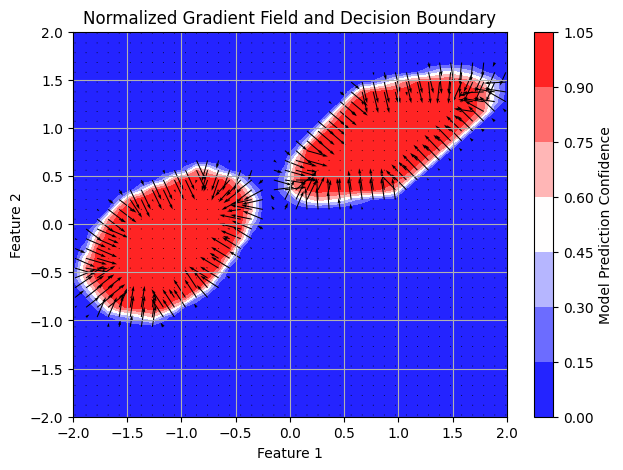

In [5]:

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 50),
                        torch.linspace(y_min, y_max, 50),
                        indexing='ij')

grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)  
grid_points.requires_grad = True

grid_preds = model(grid_points)
grid_preds.backward(torch.ones_like(grid_preds))
grid_grads = grid_points.grad.detach().numpy()

grad_magnitudes = np.linalg.norm(grid_grads, axis=1, keepdims=True)
grad_magnitudes = np.clip(grad_magnitudes, 1, 1000)
grid_grads /= grad_magnitudes

grid_grads_x = grid_grads[:, 0].reshape(xx.shape)
grid_grads_y = grid_grads[:, 1].reshape(xx.shape)
grid_preds_np = grid_preds.detach().numpy().reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, grid_preds_np, alpha=1, cmap="bwr")
plt.colorbar(label="Model Prediction Confidence")
plt.quiver(xx, yy, grid_grads_x, grid_grads_y, color="black", scale=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Normalized Gradient Field and Decision Boundary")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.savefig("points_classified_with_gradients.png")
plt.show()
